# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matminer.featurizers.conversions import StrToComposition
from pymatgen.ext.matproj import MPRester
from sklearn.linear_model import LinearRegression
from IPython.display import display
initial_df = pd.read_csv(r'Python import.csv')

**Data exploration**

In [56]:
def dataset_info(dataset):
    print(dataset.columns)
    print(dataset.describe())
    print(dataset.info())
    display(dataset)

**Data cleaning functions**

In [57]:
#This function will replace '-' values for zeroes. Also replace Nan values with zeroes
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [58]:
#filter columns that are required for us. Also convert some object columns to floats
def column_cleaning(dataset):
    columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data = dataset.loc[:,columns_to_keep]
    columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
    entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
    return entropy_data

**Launching cleaning functions on datasets**

In [59]:
#Launching functions

initial_df = parse_Nan(initial_df)
entropy_data = column_cleaning(initial_df)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
#entropy_data['ΔGOOH*-ΔGOH*'] = entropy_data['ΔGOOH*'] - entropy_data['ΔGOH*']
#Slicing only data with values for required columns, then plotting dataset
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
#dataset_info(entropy_data)
#print(entropy_data.describe())

**Element composition featurisation**

In [60]:
#Creating a column for element composition
str_comp = StrToComposition(target_col_id='composition')
entropy_data = str_comp.featurize_dataframe(entropy_data, col_id='Catalyst Materials')
#print(entropy_data)

StrToComposition: 100%|██████████| 831/831 [00:32<00:00, 25.36it/s] 


**Accessing material ID from material project + other properties**

In [61]:
with MPRester('CmGarHKLtPCjVpEkivPDYkhRJKJiB8A7') as mpr:
    results = mpr.summary.search(formula='**O3', fields=["material_id", "formula_pretty",'band_gap','formation_energy_per_atom'])
    data_list = [(result.material_id, result.formula_pretty, result.band_gap,result.formation_energy_per_atom) for result in results]
    #print(data_list)

Retrieving SummaryDoc documents: 100%|██████████| 2544/2544 [00:01<00:00, 2517.75it/s]


In [62]:
#Sorting chemical compositions in formulas alphabetically

def alph_order(composition):
    new_formula = []
    for i in composition:
        first= []
        second= []
        temp = list(i)
        capital_pos=[]
        for x in range(0, len(temp)):
            if temp[x].isupper() == True:
                capital_pos.append(x)
        for y in range(capital_pos[0], capital_pos[1]):
                first.append(temp[y])
        for z in range(capital_pos[1], len(temp)):
                second.append(temp[z])
        first = ''.join(str(v) for v in first)
        second = ''.join(str(v) for v in second)
        compound = ''.join(str(v) for v in first)
        compound = second+first+"O3"
        new_formula.append(compound)
    return new_formula

#This function is to delete the extra O3 placed in the formulas

def remove_O3(composition):
    return [i.replace("O3", "") for i in composition]

def add_o3(composition):
    return [i + "O3" for i in composition]



**Sorting list to a dictionary**

In [63]:
formula = []
material_id = []
band_gap = []
formation_energy = []
for i in data_list:
    material_id.append(i[0])
    formula.append(i[1])
    band_gap.append(i[2])
    formation_energy.append(i[3])
#Creating dictionary
#print(composition)
material_proj_data = dict((z[0], list(z[1:])) for z in zip(formula, material_id, band_gap, formation_energy))
#print(material_proj_data)
rearranged_formula = alph_order(formula)
rearranged_formula = remove_O3(rearranged_formula)
rearranged_formula = add_o3(rearranged_formula)
#Creating dictionary for re-arranged formulae
material_proj_data_rearranged = dict((z[0], list(z[1:])) for z in zip(rearranged_formula, material_id, band_gap, formation_energy))
material_proj_data.update(material_proj_data_rearranged)

**Dictionary to pandas dataframe + merge with original dataset**

In [64]:
material_proj_df = pd.DataFrame.from_dict(material_proj_data, orient= 'index')
material_proj_df = material_proj_df.reset_index()
material_proj_df.columns = ["Catalyst Materials", "material id", "band gap","formation energy per atom"]
entropy_data = entropy_data.merge(material_proj_df, on ='Catalyst Materials', how= 'left') 
#print(entropy_data)
#entropy_data.to_excel("output.xlsx",sheet_name='Sheet_name_1') 

**Dataset exploration after importing data**

In [65]:
#dataset_info(entropy_data)

**Preparing first graph**

In [66]:
def plot_scatter_entropy(data):
    x_variables = ['ΔGO*-ΔGOH*','ΔGO*','ΔGOH*']
    for i in x_variables:
        plt.scatter(data[i],data["Overpotential at xx (nearby) current density vs RHE, V"])
        plt.xlabel(i)
        plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
        if i=='ΔGO*-ΔGOH*':
            plt.savefig('Overpotential against reaction step (GO-GOH).png')
        elif i=='ΔGO*':
            plt.savefig('Overpotential against reaction step (GO).png')
        else:
            plt.savefig('Overpotential against reaction step (GOH).png')
        plt.show()

**Clustering**

In [67]:
#Creating an elbow plot to determine how many cluster will be required for model
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.savefig('Elbow plot .png')
    plt.show()

In [68]:
#Creating cluster plot using K-means method
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        # Save datasets
        if k==0:
            data.to_csv('Cluster_0.csv')
        elif k==1:
                data.to_csv('Cluster_1.csv')
        elif k==2:
            data.to_csv('Cluster_2.csv')
        elif k==3:
            data.to_csv('Cluster_3.csv')
        else:
            data.to_csv('Cluster_4.csv')
    plt.xlabel('ΔGO*-ΔGOH*')
    plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')
    plt.savefig('Overpotential against reaction step (with regions).png')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGOH*'],data['ΔGOOH*'],c=color[k])
    plt.xlabel('ΔGOH*')
    plt.ylabel('ΔGOOH*')
    plt.savefig('GOH against GOOH .png')
    plt.show()
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*'],data['ΔGOH*'],c=color[k])
    plt.xlabel('ΔGO*')
    plt.ylabel('ΔGOH*')
    plt.savefig('GO against GOH .png')
    plt.show()
    

In [69]:
# Code to form linear regression model of GOOH* against GOH*
def linear_regression_model(dataset,x,y):
    reg = LinearRegression()
    reg.fit(dataset[[x]], dataset[[y]])
    slope = reg.coef_[0][0]
    print(slope)

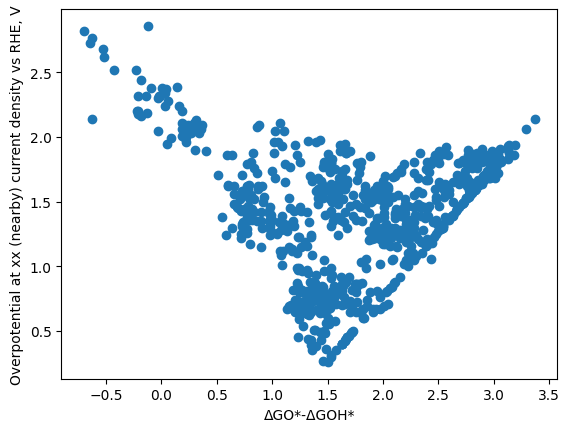

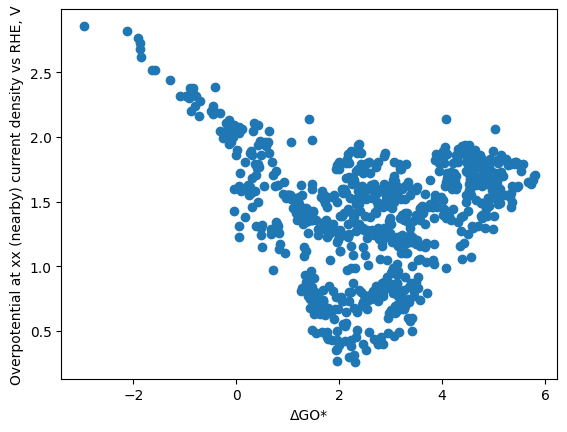

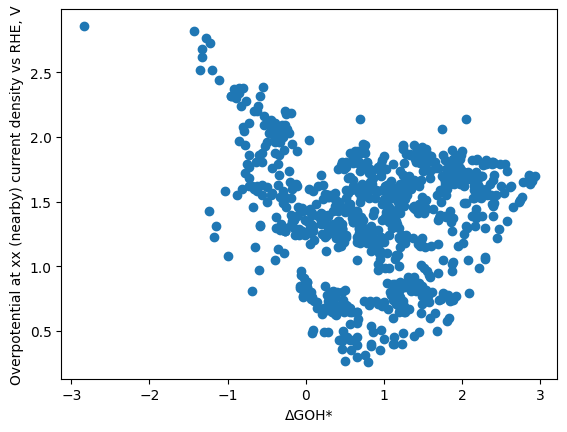

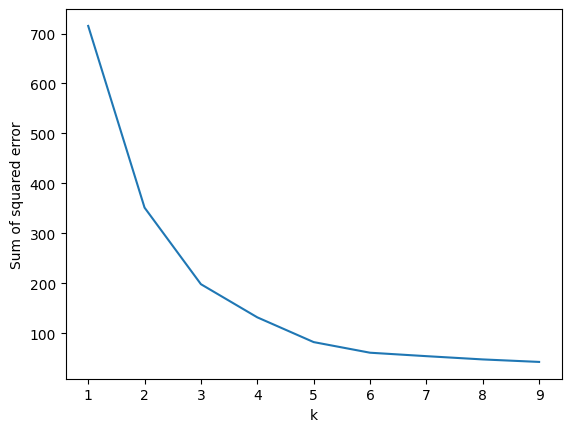

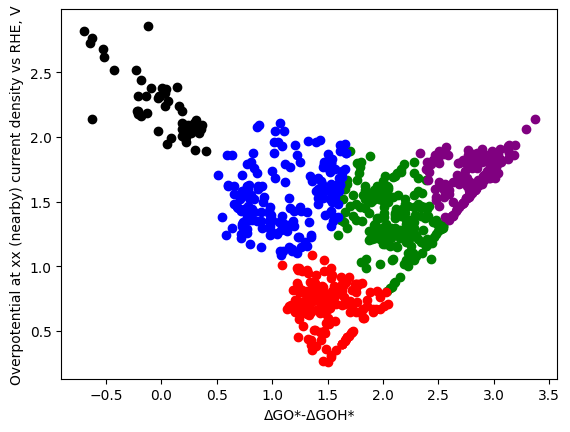

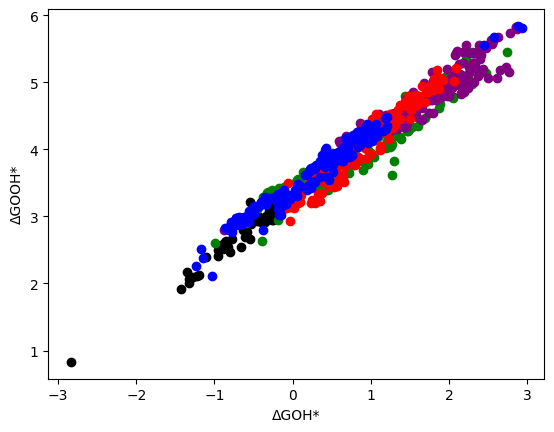

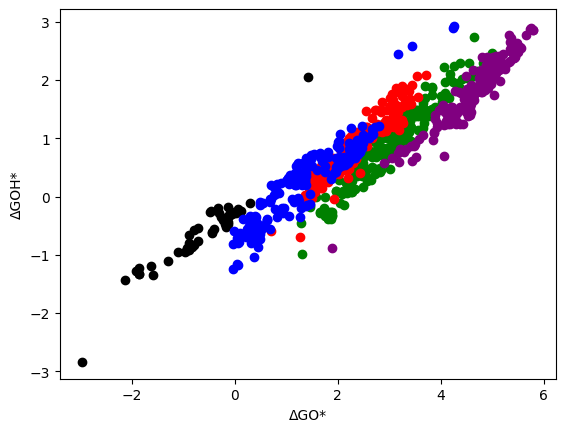

0.8164515758533752
0.5313043087091569


In [70]:
#Placing functions down
plot_scatter_entropy(entropy_data)
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data,5)
linear_regression_model(entropy_data,'ΔGOH*','ΔGOOH*')
linear_regression_model(entropy_data,'ΔGO*','ΔGOH*')

**Data exploration of optimum cluster**

In [71]:
#Function to determine proprtion of different catalyst materials in each dataset
def printing_stats_1(df_1,df_2,df_3):
    df_names = ['optimum catalysts','filtered initial','initial']
    data = [df_1, df_2 ,df_3]
    for i in range(0,3):
        print('The number of families in the', df_names[i], 'dataframe + normalized is:')
        print(data[i]['Family'].value_counts())
        print(data[i]['Family'].value_counts(normalize= True))

In [72]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = entropy_data[entropy_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
printing_stats_1(optimum_catalyst,entropy_data,initial_df)

The number of families in the optimum catalysts dataframe + normalized is:
Perovskite          176
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.871287
Bimetallic oxide    0.128713
Name: Family, dtype: float64
The number of families in the filtered initial dataframe + normalized is:
Perovskite          805
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.968712
Bimetallic oxide    0.031288
Name: Family, dtype: float64
The number of families in the initial dataframe + normalized is:
Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
Tra